In [1]:
from learning_lib.nn.monitoring.activations import ActivationMonitor
from learning_lib.nn.monitoring.weights import WeightMonitor
from learning_lib.nn.monitoring.gradient import LossGradientMonitor, LossGradientNormMonitor
from learning_lib.nn.monitoring.loss import LossMonitor

from learning_lib.nn.ffnn import FFNN
from learning_lib.nn.cnn import CNN
from learning_lib.nn.nn_base_class import NN

from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import plotly.offline as plotly
import plotly.graph_objs as go
from PIL import Image

In [2]:
%matplotlib inline
plotly.init_notebook_mode(connected=True)

# Data

In [3]:
dataset = input_data.read_data_sets("MNIST_data/", one_hot=True)
test_data = dataset.test.next_batch(1000000)
train_data = dataset.train.next_batch(1000000)
test_in = test_data[0] - train_data[0].mean()
train_in = train_data[0] - train_data[0].mean()
test_labels = test_data[1]
train_labels = train_data[1]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Simple Autoencoder

In [4]:
d = tf.data.Dataset.from_tensor_slices((train_in, train_in))
d = d.repeat(50)
d = d.batch(300)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()

In [5]:
lc = [
    784,
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 2, 'activation': tf.identity, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 64, 'activation': tf.tanh, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    },
    {
        'n_nodes': 784, 'activation': tf.identity, 'init_weight_mean': 0.0, 'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0, 'init_bias_stddev': 0.01
    }
]

In [13]:
monitors = [LossMonitor(200)]

In [14]:
ffnn = FFNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(), input_vector=pipe_out[0], train_targets_vector=pipe_out[1]
)
ffnn.init_session()

In [19]:
%%time
for epoch in range(5):
    ffnn.session.run(iterator.initializer)
    ffnn.train_online()

CPU times: user 8min, sys: 3min, total: 11min 1s
Wall time: 9min 28s


In [20]:
plotly.iplot(ffnn.monitors[0].plot())

In [133]:
inp = tf.placeholder(tf.float32, shape=(None, 784))
outp = inp
for i in range(4):
    w = ffnn.weights[i]
    b = ffnn.biases[i]
    a = ffnn.activation[i]
    outp = a(tf.matmul(outp, w) + b)
    

outp = ffnn.session.run(outp, feed_dict={inp: train_in[:20000]})

In [136]:
figure = go.Figure(
    data=[
        go.Scattergl(
            x=outp[train_labels.argmax(axis=1)[:20000] == i, 0],
            y=outp[train_labels.argmax(axis=1)[:20000] == i, 1],
            mode='markers',
            marker={'size': 2, 'opacity': 1},
            name='{}'.format(i)
        )
        for i in range(10)
    ]
)

plotly.iplot(figure)

# Convolutional Autoencoder

In [18]:
a = tf.placeholder(tf.float32, (5, 4, 4, 3))
f = tf.placeholder(tf.float32, (4, 4, 1, 3))
tf.nn.conv2d_transpose(a, f, (5, 30, 30, 1),(1, 1, 1, 1))

<tf.Tensor 'conv2d_transpose_7:0' shape=(5, 30, 30, 1) dtype=float32>

In [23]:
d = tf.data.Dataset.from_tensor_slices((train_in.reshape((110000, 28, 28, 1)), train_in))
d = d.repeat(50)
d = d.batch(300)
iterator = d.make_initializable_iterator()
pipe_out = iterator.get_next()

In [48]:
lc = [
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 1, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh
    },
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 8, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'stride_size': [1, 3, 3, 1],
        'activation': tf.tanh
    },
    {
        'layer_type': 'conv',
        'filter_size': [5, 5, 8, 8],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.001,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh
    },
    {
        'layer_type': 'reshape',
        'new_shape': [72]
    },
    {
        'layer_type': 'connected',
        'input_dim': 72,
        'output_dim': 64,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01
    },
    {
        'layer_type': 'connected',
        'input_dim': 64,
        'output_dim': 2,
        'activation': tf.identity,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01
    },
    {
        'layer_type': 'connected',
        'input_dim': 2,
        'output_dim': 64,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01
    },
    {
        'layer_type': 'connected',
        'input_dim': 64,
        'output_dim': 64,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01
    },
    {
        'layer_type': 'connected',
        'input_dim': 64,
        'output_dim': 64,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01
    },
    {
        'layer_type': 'connected',
        'input_dim': 64,
        'output_dim': 784,
        'activation': tf.tanh,
        'init_weight_mean': 0.0,
        'init_weight_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01
    }
]

In [68]:
monitors = [LossMonitor(200)]

In [69]:
cnn = CNN(
    lc, monitors=monitors, optimizer=tf.train.AdamOptimizer(), input_vector=pipe_out[0], train_targets_vector=pipe_out[1]
)
cnn.init_session()

In [70]:
%%time
for epoch in range(50):
    cnn.session.run(iterator.initializer)
    cnn.train_online()

CPU times: user 1h 36min 39s, sys: 32min 38s, total: 2h 9min 18s
Wall time: 1h 51min 11s


In [72]:
plotly.iplot(cnn.monitors[0].plot())

## Plot Embedding

In [73]:
def feed_forwards(self, input_vector, layers):
    for i in layers:
        lc = self.lc[i]

        if lc['layer_type'] == 'conv':
            input_vector = tf.nn.conv2d(
                input=input_vector,
                filter=lc['filter'],
                strides=lc['stride_size'],
                padding='VALID'
            )
            input_vector = lc['activation'](input_vector)

        elif lc['layer_type'] == 'connected':
            if len(input_vector.shape) != 2:
                flattened_dim = int(np.prod(input_vector.shape[1:]))
                input_vector = tf.reshape(input_vector, [-1, flattened_dim])

            a = lc['activation']
            w = lc['weights']
            b = lc['biases']
            input_vector = a(tf.matmul(input_vector, w) + b)

        elif lc['layer_type'] == 'pool':
            if lc['pool_type'] == 'average':
                input_vector = tf.nn.avg_pool(
                    value=input_vector,
                    ksize=lc['pool_size'],
                    strides=lc['stride_size'],
                    padding='SAME'
                )
            elif lc['pool_type'] == 'max':
                input_vector = tf.nn.max_pool(
                    value=input_vector,
                    ksize=lc['pool_size'],
                    strides=lc['stride_size'],
                    padding='SAME'
                )
    return input_vector

In [137]:
inp = tf.placeholder(tf.float32, (None, 28, 28, 1))
outp = feed_forwards(cnn, inp, range(6))
outp = cnn.session.run(outp, feed_dict={inp: train_in.reshape((110000, 28, 28, 1))[:20000]})

In [138]:
figure = go.Figure(
    data=[
        go.Scattergl(
            x=outp[train_labels.argmax(axis=1)[:20000] == i, 0],
            y=outp[train_labels.argmax(axis=1)[:20000] == i, 1],
            mode='markers',
            marker={'size': 2, 'opacity': 1},
            name='{}'.format(i)
        )
        for i in range(10)
    ]
)

plotly.iplot(figure)

## Visualize Filters

In [76]:
filters_1 = cnn.session.run(cnn.lc[0]['filter'])

In [130]:
n = 18
image = train_in.reshape((110000, 28, 28, 1))[n:n+1, :, :, :]

f1 = np.repeat(image[0,:,:,0], 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

In [143]:
f = cnn.session.run(feed_forwards(cnn, cnn.input, range(1)), {cnn.input: image})[0, :, :, 0]
f1 = np.repeat(f, 10, 0)
f1 = np.repeat(f1, 10, 1)
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

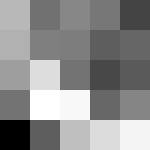

In [117]:
f1 = np.repeat(filters_1[:,:,0,2], 30, 0)
f1 = np.repeat(f1, 30, 1)
f1 = f1
Image.fromarray((255 * (f1 - f1.min()) / (f1.max() - f1.min())).astype('uint8'), mode='L')

# TNSE

In [59]:
tsne = TSNE()
outtsne = tsne.fit_transform(train_in[:20000])

In [63]:
figure = go.Figure(
    data=[
        go.Scattergl(
            x=outtsne[train_labels.argmax(axis=1)[:20000] == i, 0],
            y=outtsne[train_labels.argmax(axis=1)[:20000] == i, 1],
            mode='markers',
            marker={'size': 1.9, 'opacity': 1}
        )
        for i in range(10)
    ]
)

plotly.iplot(figure)